# Data preparation

## Table of Contents
- [Data gathering](#gather)
- [Initial data exploration](#explo-start)
    - [FRED time series plots](#explo-fred)
    - [FDIC distributions and outlier detection](#explo-fdic)
    - [Merging FRED and FDIC data](#explo-merge)
    - [Summary statistics](#explo-summary)
    - [Correlation heatmap](#explo-corr)
- [Saving data for analysis](#supervised)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pyarrow.feather import read_feather, write_feather
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 50)

In banking, forecasting deposit movements helps to manage cash flows and inform lending and investing decisions. Our goal is specifically to forecast bank deposit size using key macroeconomic indicators and bank-level data.

[Github repository](https://github.com/hughdingb58/deposit_size_prediction)

<a id="gather"></a>
# Data gathering

In [ ]:
%run "../scripts/gather_api_data.py"

In [3]:
# FRED data
econ = read_feather("../data/fred_econ.feather")
econ.head()

,date,gdp,cpi,unemployment_rate,fed_fund_rate,treasury_10yr_constant_maturity_rate,private_domestic_investment,private_domestic_investment_excl_iva_ccadj,fed_govt_expenditures,state_local_govt_expenditures,net_exports_good_services,housing_starts,new_one_family_houses_sold,case_shiller_us_national_home_price_index,advance_real_retail_food_services_sales,industrial_production_index,disposable_personal_income,retail_food_services_sales,personal_savings_rate,umich_consumer_sentiment_index,household_debt_service_payments_pct_disposable_income,credit_card_delinquency_rate,consumer_credit_owned_securitized_outstanding,cpi_urban_consumers_less_food_energy,avg_hrly_earnings_production_nonsupervisory_employees,real_median_household_income,pce,total_vehicle_sales,year,quarter
0,2000-01-01,13878.147,168.8,4.0,5.45,6.66,2351.223,2287.827,1866.308,1308.322,-356.583,1636.0,873.0,100.000,-0.8,91.4251,9799.9,158325.0,4.5,112.0,11.581974,4.43,1538.52018,179.3,13.75,67470.0,NaN,18.635,2000,1
1,2000-04-01,14130.908,171.3,3.8,6.02,5.99,2490.501,2424.549,1908.645,1331.564,-362.501,1626.0,841.0,102.540,-1.6,92.6838,9913.7,158599.0,4.3,109.2,11.727593,4.51,1570.52774,180.3,13.89,NaN,NaN,17.939,2000,2
2,2000-07-01,14145.312,172.8,4.0,6.54,6.05,2466.375,2394.141,1918.617,1357.309,-393.867,1463.0,887.0,105.721,-0.4,92.8458,10035.9,157863.0,4.7,108.3,11.883636,4.53,1629.75144,181.5,14.02,NaN,NaN,17.316,2000,3
3,2000-10-01,14229.765,174.0,3.9,6.51,5.74,2471.534,2395.566,1938.796,1382.641,-411.343,1549.0,933.0,107.728,-0.2,92.6418,10139.2,159245.0,4.3,105.8,12.072070,4.57,1684.59932,182.6,14.17,NaN,NaN,17.514,2000,4
4,2001-01-01,14183.120,175.1,4.2,5.98,5.16,2358.969,2285.261,1982.626,1431.089,-402.653,1600.0,936.0,109.214,0.8,91.8903,10211.7,158789.0,4.5,94.7,12.175219,4.81,1729.85168,183.9,14.29,66360.0,NaN,17.652,2001,1


FDIC data is read from its [API](https://banks.data.fdic.gov/docs/).

In [4]:
# FDIC data
financials = read_feather("../data/fdic_financials.feather")
financials.head()

,name,date,year,quarter,total_assets,total_interest_expense_quarterly,total_deposits,non_interest_expense_quarterly,debt_securities_maturity_1yr_or_less,net_income_quarterly
0,15 BEACH MHC,2022-03-31,2022,1,364211,988,295932,6660,4889,445
1,15 BEACH MHC,2022-06-30,2022,2,365856,952,298841,6772,4095,581
2,15 BEACH MHC,2022-09-30,2022,3,360641,964,291425,6900,5580,674
3,15 BEACH MHC,2022-12-31,2022,4,356248,1360,286909,8168,3447,384
4,15 BEACH MHC,2023-03-31,2023,1,351115,2144,281149,7204,7457,435


We set aside some bank rows for robustness checks later on.

In [5]:
# Get list of sample banks
rng = np.random.default_rng(0)
bank_sample = rng.choice(list(set(financials["name"])), size=5, replace=False)
# Manually append a large and two medium banks
bank_sample_map = {
    "BANK OF AMERICA CORP": "large",
    "TORONTO-DOMINION BANK THE": "intermediate",
    "CHARLES SCHWAB CORP THE": "intermediate",
}
for bank in bank_sample:
    bank_sample_map[bank] = "small"
bank_sample = list(bank_sample) + list(bank_sample_map.keys())
bank_sample

['CENTRE 1 BCORP INC',
 'OHNWARD BANCSHARES INC',
 'BK JAMES FINL GROUP INC',
 'GREAT OAKS FINL HOLDINGS INC',
 'PEOPLES BCORP OF NC INC',
 'BANK OF AMERICA CORP',
 'TORONTO-DOMINION BANK THE',
 'CHARLES SCHWAB CORP THE',
 'CENTRE 1 BCORP INC',
 'OHNWARD BANCSHARES INC',
 'BK JAMES FINL GROUP INC',
 'GREAT OAKS FINL HOLDINGS INC',
 'PEOPLES BCORP OF NC INC']

In [6]:
# Move these banks to their own df
financials_sample = financials[financials["name"].isin(bank_sample)]
financials = financials[~financials["name"].isin(bank_sample)]

<a id="explo-start"></a>
# Initial data exploration

We first visualize the FDIC and FRED data separately, and then join them together to check for summary statistics and correlations.

<a id="explo-fred"></a>
## FRED time series plots

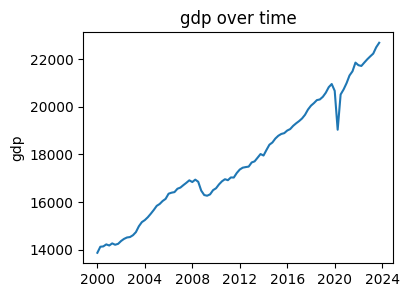

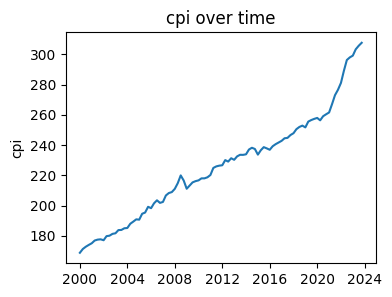

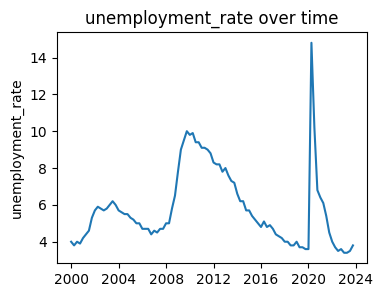

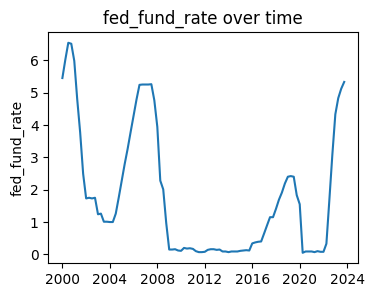

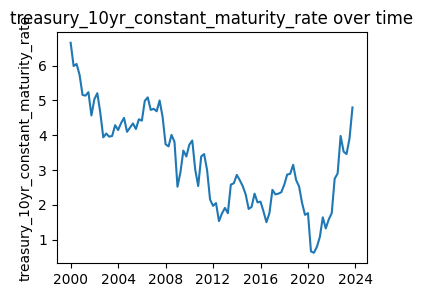

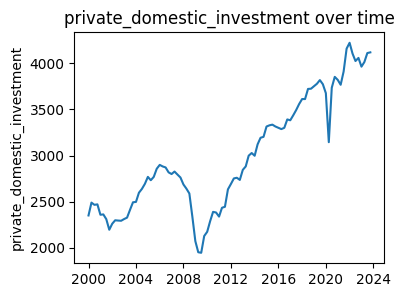

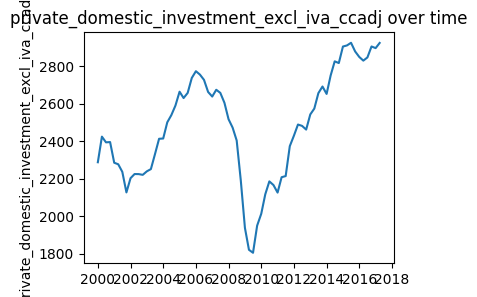

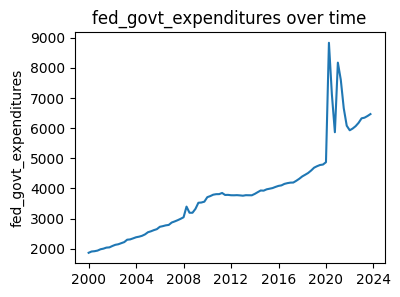

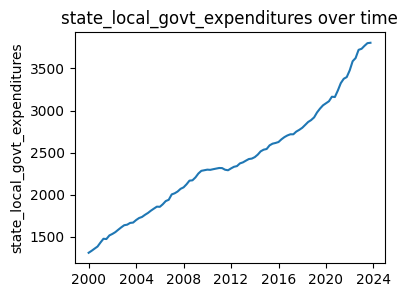

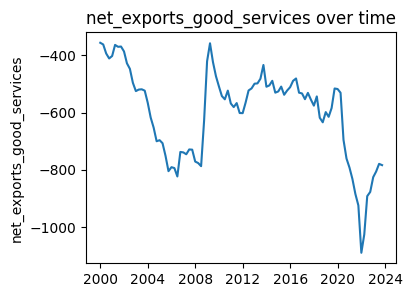

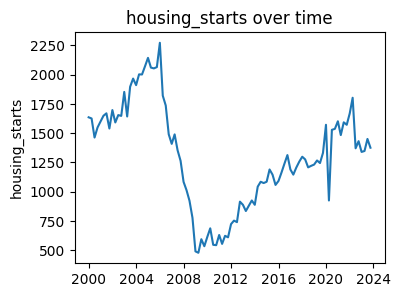

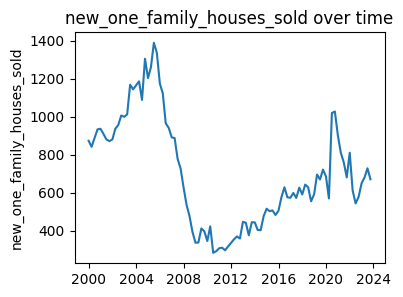

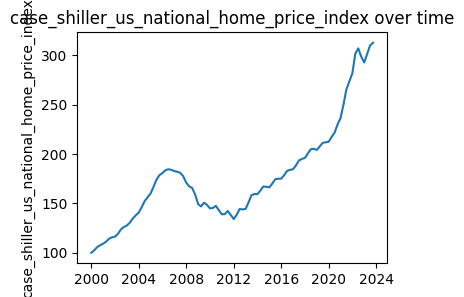

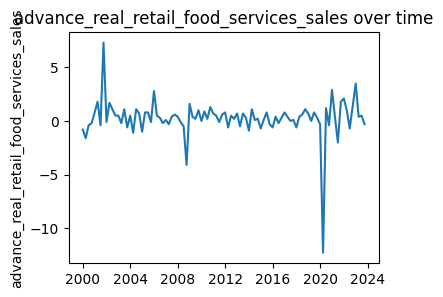

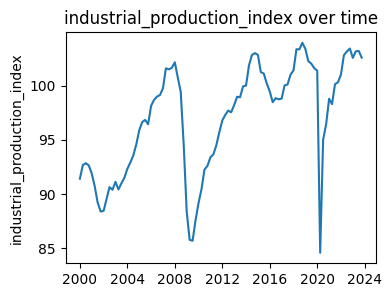

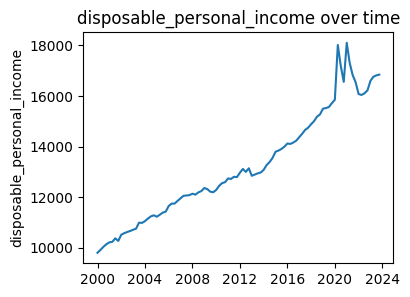

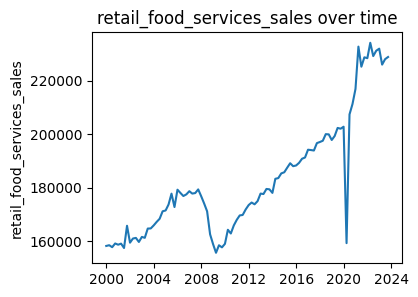

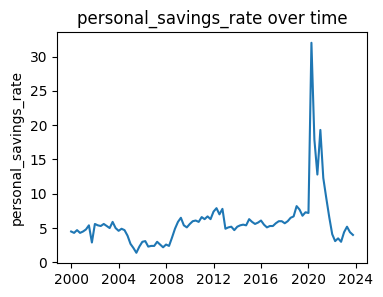

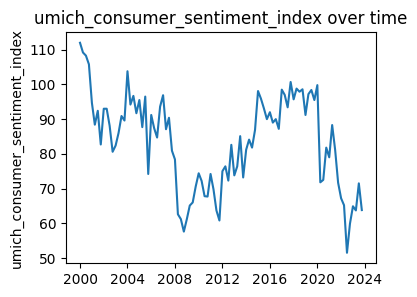

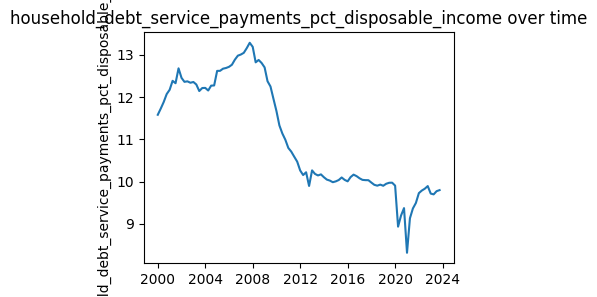

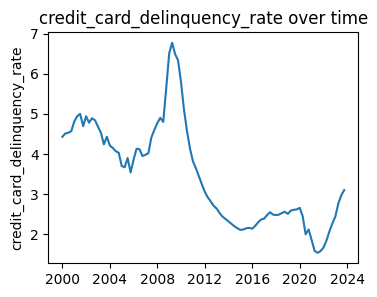

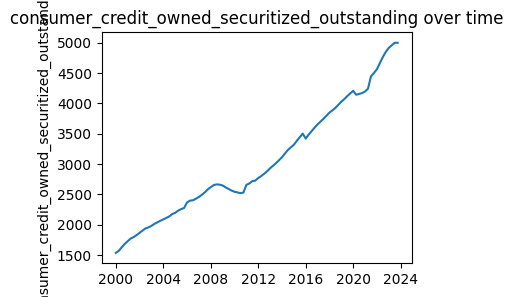

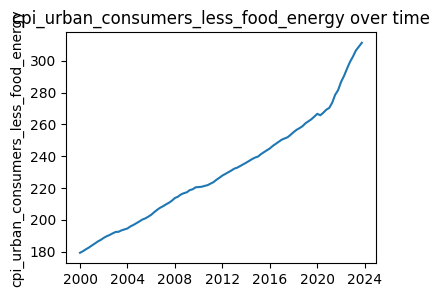

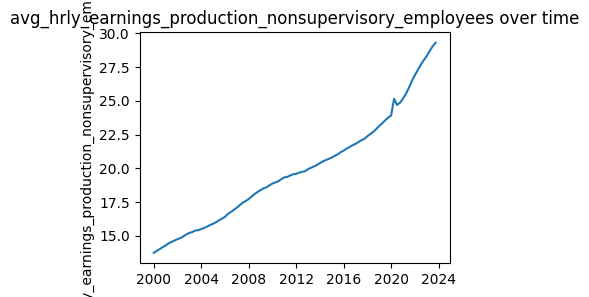

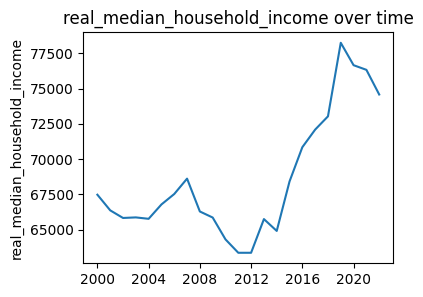

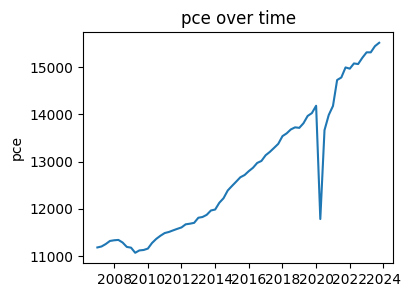

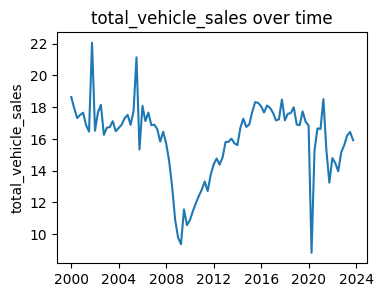

In [7]:
for indicator in econ.columns[1:-2]:
    plt.figure(figsize=(4, 3))
    ax = sns.lineplot(econ, x="date", y=indicator)
    ax.set_title(indicator + " over time")
    ax.set_xlabel("")
    plt.show()

All FRED indicators appear to follow reasonable and expected trends over time (naturally with fluctuations during the 2020 pandemic), and there do not appear to be significant outliers.

<a id="explo-fdic"></a>
## FDIC distributions and outlier detection

We first plot a histogram of a proxy of our outcome variable, deposit size.

<Axes: xlabel='total_deposits', ylabel='Count'>

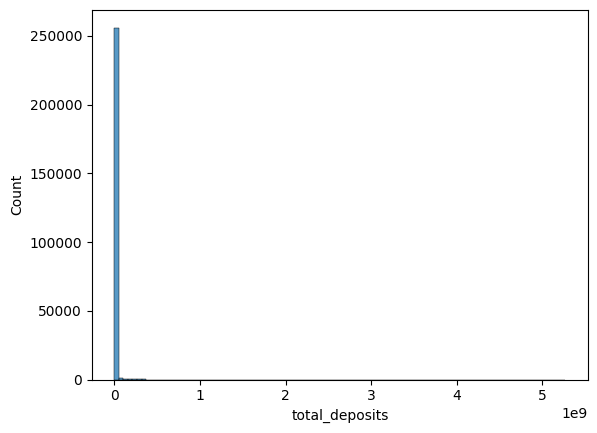

In [8]:
sns.histplot(financials, x="total_deposits", bins=100)

We see that the vast majority of banks have deposit sizes that are far smaller than the largest banks. However, since our analysis is from a macroeconomic perspective, we are interested in categories of banks rather than individual banks. We aggregate the banks into three equally weighted categories for large, intermediate, and small banks (based on [OCC categorizations](https://www.occ.gov/news-issuances/bulletins/2021/bulletin-2021-5.html)).

In [9]:
financials["total_assets_last"] = financials.groupby(["name"])[
    "total_assets"
].transform("last")
financials["category"] = np.select(
    [
        financials["total_assets_last"] >= 2500000000,
        financials["total_assets_last"] >= 600000000,
    ],
    ["large", "intermediate"],
    default="small",
)

financials.groupby(["category"]).agg({"total_assets_last": "sum"})

,total_assets_last
category,
intermediate,532444389472
large,1034669817588
small,1051598736368


These thresholds seem reasonable (the three aggregate categories are comparably sized), so we will use them for now.

In [10]:
financials_agg = (
    financials.drop(["name"], axis=1)
    .groupby(["category", "date", "year", "quarter"])
    .agg("sum")
    .reset_index()
    .drop("total_assets_last", axis=1)
)
financials_agg.head()

,category,date,year,quarter,total_assets,total_interest_expense_quarterly,total_deposits,non_interest_expense_quarterly,debt_securities_maturity_1yr_or_less,net_income_quarterly
0,intermediate,2000-03-31,2000,1,558319105,20550976,367147508,24161608,14341318,2571182
1,intermediate,2000-06-30,2000,2,597203394,23254692,388896435,24171144,15556297,2146797
2,intermediate,2000-09-30,2000,3,619144497,26694724,394527160,25132440,16135172,2189389
3,intermediate,2000-12-31,2000,4,641096047,28115956,410358973,25822732,16514098,2181289
4,intermediate,2001-03-31,2001,1,730053169,29287200,479205515,29143224,15717210,2319569


Now that we have reduced our data to aggregate categories we are confident we are interested in, we generate histograms for each metric, each across a period of 6 years, to visually inspect for unusual distributions.

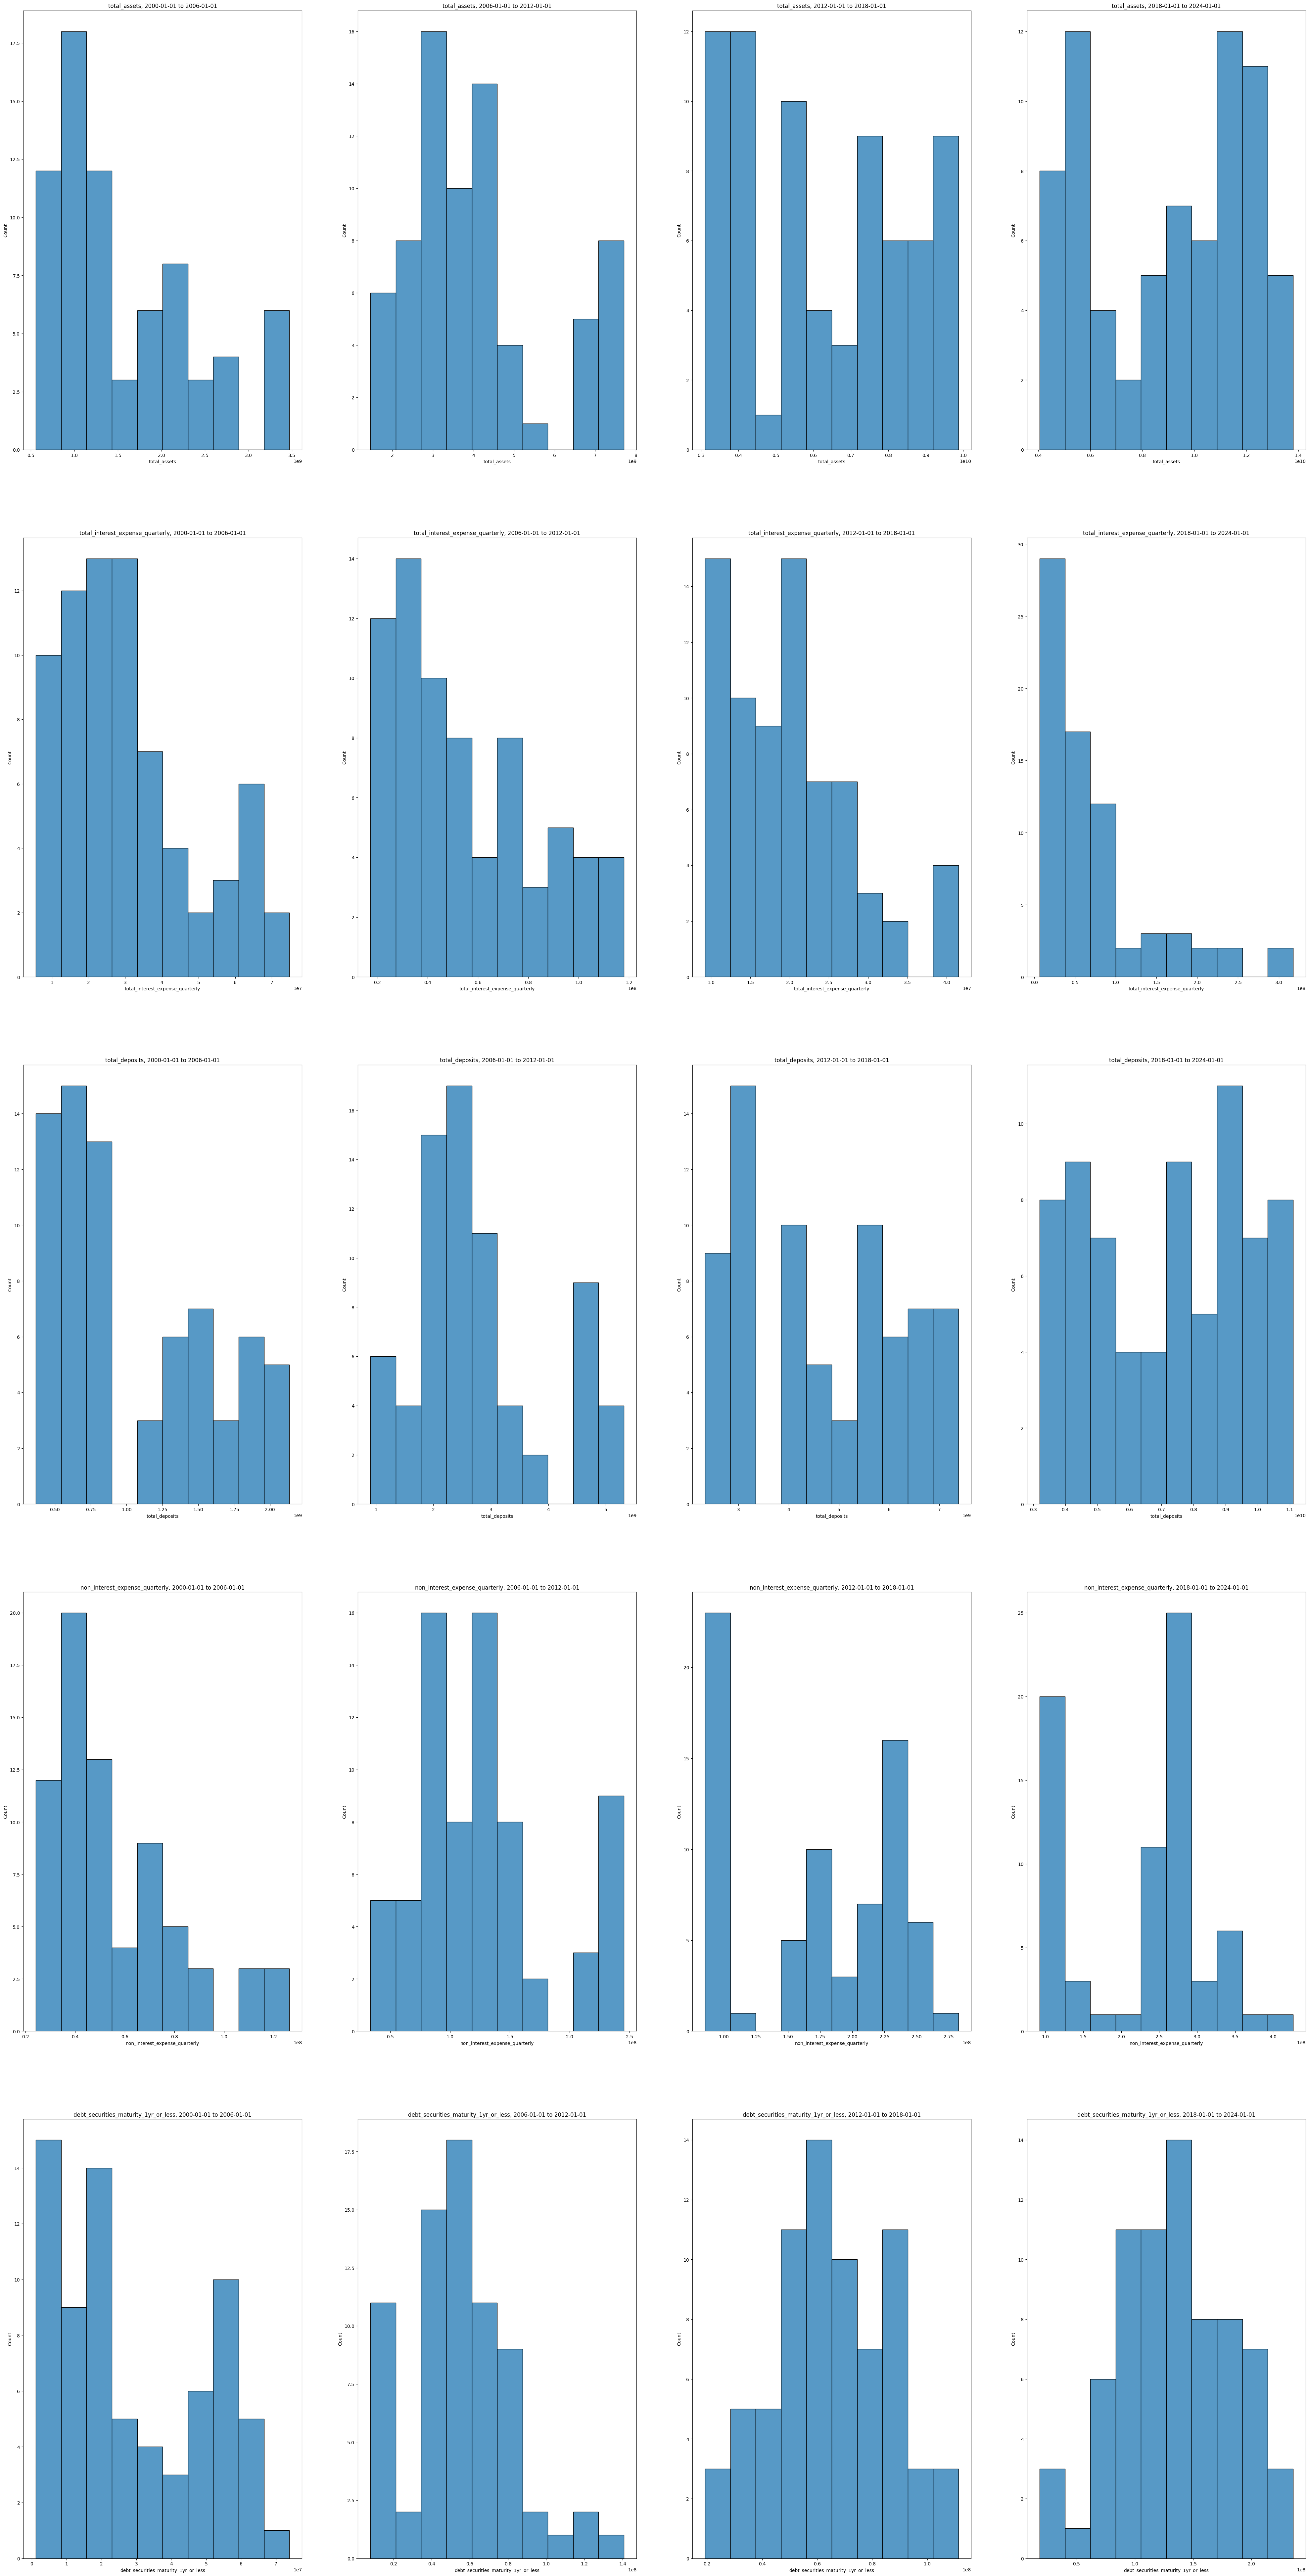

In [11]:
date_ranges = ["2000-01-01", "2006-01-01", "2012-01-01", "2018-01-01", "2024-01-01"]

desc_col_num = 4
fig, axes = plt.subplots(
    financials_agg.shape[1] - desc_col_num - 1, len(date_ranges) - 1, figsize=(50, 100)
)

for i in range(1, len(date_ranges)):
    curr_data = financials_agg[
        (financials_agg["date"] >= date_ranges[i - 1])
        & (financials_agg["date"] < date_ranges[i])
    ]
    for j in range(desc_col_num, financials_agg.shape[1] - 1):
        metric = financials_agg.columns[j]
        sns.histplot(curr_data, x=metric, bins=10, ax=axes[j - desc_col_num, i - 1])
        axes[j - desc_col_num, i - 1].set_title(
            metric + ", " + date_ranges[i - 1] + " to " + date_ranges[i]
        )

The values seem to generally follow a very roughly normal distribution (with some skew at times), and the outliers do not seem too substantial. This matches what we would expect from the variables.

<a id="explo-merge"></a>
## Merging FRED and FDIC data

In [12]:
# Merge on quarter
df_full = pd.merge(econ.drop("date", axis=1), financials_agg)
df_samples_full = pd.merge(econ.drop("date", axis=1), financials_sample)
# Rearrange columns
cols = list(df_full.columns)
for col in ["total_deposits", "quarter", "year", "date", "category"]:
    cols.insert(0, cols.pop(cols.index(col)))
df_full = df_full[cols].sort_values(["date", "category"])
df_full.head()

,category,date,year,quarter,total_deposits,gdp,cpi,unemployment_rate,fed_fund_rate,treasury_10yr_constant_maturity_rate,private_domestic_investment,private_domestic_investment_excl_iva_ccadj,fed_govt_expenditures,state_local_govt_expenditures,net_exports_good_services,housing_starts,new_one_family_houses_sold,case_shiller_us_national_home_price_index,advance_real_retail_food_services_sales,industrial_production_index,disposable_personal_income,retail_food_services_sales,personal_savings_rate,umich_consumer_sentiment_index,household_debt_service_payments_pct_disposable_income,credit_card_delinquency_rate,consumer_credit_owned_securitized_outstanding,cpi_urban_consumers_less_food_energy,avg_hrly_earnings_production_nonsupervisory_employees,real_median_household_income,pce,total_vehicle_sales,total_assets,total_interest_expense_quarterly,non_interest_expense_quarterly,debt_securities_maturity_1yr_or_less,net_income_quarterly
0,intermediate,2000-03-31,2000,1,367147508,13878.147,168.8,4.0,5.45,6.66,2351.223,2287.827,1866.308,1308.322,-356.583,1636.0,873.0,100.00,-0.8,91.4251,9799.9,158325.0,4.5,112.0,11.581974,4.43,1538.52018,179.3,13.75,67470.0,NaN,18.635,558319105,20550976,24161608,14341318,2571182
1,large,2000-03-31,2000,1,440860254,13878.147,168.8,4.0,5.45,6.66,2351.223,2287.827,1866.308,1308.322,-356.583,1636.0,873.0,100.00,-0.8,91.4251,9799.9,158325.0,4.5,112.0,11.581974,4.43,1538.52018,179.3,13.75,67470.0,NaN,18.635,673086924,16940052,30717096,11665710,993225
2,small,2000-03-31,2000,1,1184531829,13878.147,168.8,4.0,5.45,6.66,2351.223,2287.827,1866.308,1308.322,-356.583,1636.0,873.0,100.00,-0.8,91.4251,9799.9,158325.0,4.5,112.0,11.581974,4.43,1538.52018,179.3,13.75,67470.0,NaN,18.635,1668180110,58927516,54333668,47447839,5107169
3,intermediate,2000-06-30,2000,2,388896435,14130.908,171.3,3.8,6.02,5.99,2490.501,2424.549,1908.645,1331.564,-362.501,1626.0,841.0,102.54,-1.6,92.6838,9913.7,158599.0,4.3,109.2,11.727593,4.51,1570.52774,180.3,13.89,NaN,NaN,17.939,597203394,23254692,24171144,15556297,2146797
4,large,2000-06-30,2000,2,453740157,14130.908,171.3,3.8,6.02,5.99,2490.501,2424.549,1908.645,1331.564,-362.501,1626.0,841.0,102.54,-1.6,92.6838,9913.7,158599.0,4.3,109.2,11.727593,4.51,1570.52774,180.3,13.89,NaN,NaN,17.939,705410574,20369112,30386532,9522279,2171850


In [13]:
cols_sample = cols.copy()
cols_sample[0] = "name"
df_samples_full = df_samples_full[cols_sample].sort_values(["date", "name"])
df_samples_full

,name,date,year,quarter,total_deposits,gdp,cpi,unemployment_rate,fed_fund_rate,treasury_10yr_constant_maturity_rate,private_domestic_investment,private_domestic_investment_excl_iva_ccadj,fed_govt_expenditures,state_local_govt_expenditures,net_exports_good_services,housing_starts,new_one_family_houses_sold,case_shiller_us_national_home_price_index,advance_real_retail_food_services_sales,industrial_production_index,disposable_personal_income,retail_food_services_sales,personal_savings_rate,umich_consumer_sentiment_index,household_debt_service_payments_pct_disposable_income,credit_card_delinquency_rate,consumer_credit_owned_securitized_outstanding,cpi_urban_consumers_less_food_energy,avg_hrly_earnings_production_nonsupervisory_employees,real_median_household_income,pce,total_vehicle_sales,total_assets,total_interest_expense_quarterly,non_interest_expense_quarterly,debt_securities_maturity_1yr_or_less,net_income_quarterly
0,BANK OF AMERICA CORP,2000-03-31,2000,1,738900876,13878.147,168.800,4.0,5.45,6.66,2351.223,2287.827,1866.308,1308.322,-356.583,1636.0,873.0,100.000,-0.8,91.4251,9799.9,158325.0,4.5,112.0,11.581974,4.43,1538.52018,179.30,13.75,67470.0,NaN,18.635,1210111802,37204552,33232424,10868264,4134952
1,CENTRE 1 BCORP INC,2000-03-31,2000,1,266365,13878.147,168.800,4.0,5.45,6.66,2351.223,2287.827,1866.308,1308.322,-356.583,1636.0,873.0,100.000,-0.8,91.4251,9799.9,158325.0,4.5,112.0,11.581974,4.43,1538.52018,179.30,13.75,67470.0,NaN,18.635,307902,11288,9656,14052,681
2,OHNWARD BANCSHARES INC,2000-03-31,2000,1,856989,13878.147,168.800,4.0,5.45,6.66,2351.223,2287.827,1866.308,1308.322,-356.583,1636.0,873.0,100.000,-0.8,91.4251,9799.9,158325.0,4.5,112.0,11.581974,4.43,1538.52018,179.30,13.75,67470.0,NaN,18.635,1125591,44796,26424,46125,3087
3,PEOPLES BCORP OF NC INC,2000-03-31,2000,1,393979,13878.147,168.800,4.0,5.45,6.66,2351.223,2287.827,1866.308,1308.322,-356.583,1636.0,873.0,100.000,-0.8,91.4251,9799.9,158325.0,4.5,112.0,11.581974,4.43,1538.52018,179.30,13.75,67470.0,NaN,18.635,450885,16060,15440,2525,1270
4,TORONTO-DOMINION BANK THE,2000-03-31,2000,1,5374191,13878.147,168.800,4.0,5.45,6.66,2351.223,2287.827,1866.308,1308.322,-356.583,1636.0,873.0,100.000,-0.8,91.4251,9799.9,158325.0,4.5,112.0,11.581974,4.43,1538.52018,179.30,13.75,67470.0,NaN,18.635,5722038,237084,53756,4607669,3518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649,CHARLES SCHWAB CORP THE,2023-12-31,2023,4,290411000,22679.255,307.671,3.8,5.33,4.80,4118.672,NaN,6465.591,3805.228,-783.734,1376.0,670.0,312.769,-0.3,102.5683,16847.8,228767.0,4.0,63.8,9.796931,3.10,4998.25192,311.39,29.29,NaN,15519.9,15.919,342521000,5880000,1808000,12645000,101000
650,GREAT OAKS FINL HOLDINGS INC,2023-12-31,2023,4,321304,22679.255,307.671,3.8,5.33,4.80,4118.672,NaN,6465.591,3805.228,-783.734,1376.0,670.0,312.769,-0.3,102.5683,16847.8,228767.0,4.0,63.8,9.796931,3.10,4998.25192,311.39,29.29,NaN,15519.9,15.919,352290,5636,10096,942,1333
651,OHNWARD BANCSHARES INC,2023-12-31,2023,4,3515496,22679.255,307.671,3.8,5.33,4.80,4118.672,NaN,6465.591,3805.228,-783.734,1376.0,670.0,312.769,-0.3,102.5683,16847.8,228767.0,4.0,63.8,9.796931,3.10,4998.25192,311.39,29.29,NaN,15519.9,15.919,4503150,81888,92148,152544,11406
652,PEOPLES BCORP OF NC INC,2023-12-31,2023,4,1393635,22679.255,307.671,3.8,5.33,4.80,4118.672,NaN,6465.591,3805.228,-783.734,1376.0,670.0,312.769,-0.3,102.5683,16847.8,228767.0,4.0,63.8,9.796931,3.10,4998.25192,311.39,29.29,NaN,15519.9,15.919,1635448,22392,57684,2989,3777


Next, we scale and center the metrics so that they are all treated equally when modelling. We apply the same scaling from the main dataset to our sample data that we use for robustness checks.

In [14]:
df = df_full.copy()
df_samples = df_samples_full.copy()
for i in df.columns[4:]:
    df_mean = np.mean(df[i])
    df_scale = np.max([np.nanmax(df[i]), np.nanmin(df[i]) * -1])
    df[i] = df[i] - df_mean
    df[i] = df[i] / df_scale

    df_samples[i] = df_samples[i] - df_mean
    df_samples[i] = df_samples[i] / df_scale
df.head()

,category,date,year,quarter,total_deposits,gdp,cpi,unemployment_rate,fed_fund_rate,treasury_10yr_constant_maturity_rate,private_domestic_investment,private_domestic_investment_excl_iva_ccadj,fed_govt_expenditures,state_local_govt_expenditures,net_exports_good_services,housing_starts,new_one_family_houses_sold,case_shiller_us_national_home_price_index,advance_real_retail_food_services_sales,industrial_production_index,disposable_personal_income,retail_food_services_sales,personal_savings_rate,umich_consumer_sentiment_index,household_debt_service_payments_pct_disposable_income,credit_card_delinquency_rate,consumer_credit_owned_securitized_outstanding,cpi_urban_consumers_less_food_energy,avg_hrly_earnings_production_nonsupervisory_employees,real_median_household_income,pce,total_vehicle_sales,total_assets,total_interest_expense_quarterly,non_interest_expense_quarterly,debt_securities_maturity_1yr_or_less,net_income_quarterly
0,intermediate,2000-03-31,2000,1,-0.320456,-0.172706,-0.185839,-0.121974,0.560238,0.509916,-0.152421,-0.065298,-0.225582,-0.285041,0.224295,0.146654,0.125720,-0.245369,-0.086721,-0.053357,-0.188762,-0.105106,-0.04043,0.253748,0.039778,0.143002,-0.300376,-0.166460,-0.209258,-0.01463,NaN,0.120187,-0.339149,-0.072177,-0.281381,-0.237229,-0.241466
1,large,2000-03-31,2000,1,-0.313819,-0.172706,-0.185839,-0.121974,0.560238,0.509916,-0.152421,-0.065298,-0.225582,-0.285041,0.224295,0.146654,0.125720,-0.245369,-0.086721,-0.053357,-0.188762,-0.105106,-0.04043,0.253748,0.039778,0.143002,-0.300376,-0.166460,-0.209258,-0.01463,NaN,0.120187,-0.330829,-0.083550,-0.266007,-0.248587,-0.276004
2,small,2000-03-31,2000,1,-0.246853,-0.172706,-0.185839,-0.121974,0.560238,0.509916,-0.152421,-0.065298,-0.225582,-0.285041,0.224295,0.146654,0.125720,-0.245369,-0.086721,-0.053357,-0.188762,-0.105106,-0.04043,0.253748,0.039778,0.143002,-0.300376,-0.166460,-0.209258,-0.01463,NaN,0.120187,-0.258697,0.048691,-0.210623,-0.096685,-0.185958
3,intermediate,2000-06-30,2000,2,-0.318498,-0.161561,-0.177713,-0.135487,0.647394,0.409316,-0.119436,-0.018563,-0.220787,-0.278933,0.218864,0.142254,0.102682,-0.237248,-0.151762,-0.041247,-0.182477,-0.103936,-0.04668,0.228748,0.050737,0.154819,-0.293972,-0.163249,-0.204478,NaN,NaN,0.088630,-0.336330,-0.063662,-0.281358,-0.232071,-0.250755
4,large,2000-06-30,2000,2,-0.312659,-0.161561,-0.177713,-0.135487,0.647394,0.409316,-0.119436,-0.018563,-0.220787,-0.278933,0.218864,0.142254,0.102682,-0.237248,-0.151762,-0.041247,-0.182477,-0.103936,-0.04668,0.228748,0.050737,0.154819,-0.293972,-0.163249,-0.204478,NaN,NaN,0.088630,-0.328486,-0.072750,-0.266782,-0.257686,-0.250206


In [15]:
df_samples.head()

,name,date,year,quarter,total_deposits,gdp,cpi,unemployment_rate,fed_fund_rate,treasury_10yr_constant_maturity_rate,private_domestic_investment,private_domestic_investment_excl_iva_ccadj,fed_govt_expenditures,state_local_govt_expenditures,net_exports_good_services,housing_starts,new_one_family_houses_sold,case_shiller_us_national_home_price_index,advance_real_retail_food_services_sales,industrial_production_index,disposable_personal_income,retail_food_services_sales,personal_savings_rate,umich_consumer_sentiment_index,household_debt_service_payments_pct_disposable_income,credit_card_delinquency_rate,consumer_credit_owned_securitized_outstanding,cpi_urban_consumers_less_food_energy,avg_hrly_earnings_production_nonsupervisory_employees,real_median_household_income,pce,total_vehicle_sales,total_assets,total_interest_expense_quarterly,non_interest_expense_quarterly,debt_securities_maturity_1yr_or_less,net_income_quarterly
0,BANK OF AMERICA CORP,2000-03-31,2000,1,-0.286981,-0.172706,-0.185839,-0.121974,0.560238,0.509916,-0.152421,-0.065298,-0.225582,-0.285041,0.224295,0.146654,0.12572,-0.245369,-0.086721,-0.053357,-0.188762,-0.105106,-0.04043,0.253748,0.039778,0.143002,-0.300376,-0.16646,-0.209258,-0.01463,NaN,0.120187,-0.291901,-0.019726,-0.260108,-0.251972,-0.207238
1,CENTRE 1 BCORP INC,2000-03-31,2000,1,-0.353493,-0.172706,-0.185839,-0.121974,0.560238,0.509916,-0.152421,-0.065298,-0.225582,-0.285041,0.224295,0.146654,0.12572,-0.245369,-0.086721,-0.053357,-0.188762,-0.105106,-0.04043,0.253748,0.039778,0.143002,-0.300376,-0.16646,-0.209258,-0.01463,NaN,0.120187,-0.379598,-0.136868,-0.338021,-0.298051,-0.297729
2,OHNWARD BANCSHARES INC,2000-03-31,2000,1,-0.353440,-0.172706,-0.185839,-0.121974,0.560238,0.509916,-0.152421,-0.065298,-0.225582,-0.285041,0.224295,0.146654,0.12572,-0.245369,-0.086721,-0.053357,-0.188762,-0.105106,-0.04043,0.253748,0.039778,0.143002,-0.300376,-0.16646,-0.209258,-0.01463,NaN,0.120187,-0.379539,-0.136763,-0.337981,-0.297915,-0.297676
3,PEOPLES BCORP OF NC INC,2000-03-31,2000,1,-0.353482,-0.172706,-0.185839,-0.121974,0.560238,0.509916,-0.152421,-0.065298,-0.225582,-0.285041,0.224295,0.146654,0.12572,-0.245369,-0.086721,-0.053357,-0.188762,-0.105106,-0.04043,0.253748,0.039778,0.143002,-0.300376,-0.16646,-0.209258,-0.01463,NaN,0.120187,-0.379588,-0.136853,-0.338007,-0.298100,-0.297716
4,TORONTO-DOMINION BANK THE,2000-03-31,2000,1,-0.353033,-0.172706,-0.185839,-0.121974,0.560238,0.509916,-0.152421,-0.065298,-0.225582,-0.285041,0.224295,0.146654,0.12572,-0.245369,-0.086721,-0.053357,-0.188762,-0.105106,-0.04043,0.253748,0.039778,0.143002,-0.300376,-0.16646,-0.209258,-0.01463,NaN,0.120187,-0.379206,-0.136157,-0.337917,-0.278550,-0.297667


<a id="explo-summary"></a>
## Summary statistics

In [16]:
df.describe()

,date,year,quarter,total_deposits,gdp,cpi,unemployment_rate,fed_fund_rate,treasury_10yr_constant_maturity_rate,private_domestic_investment,private_domestic_investment_excl_iva_ccadj,fed_govt_expenditures,state_local_govt_expenditures,net_exports_good_services,housing_starts,new_one_family_houses_sold,case_shiller_us_national_home_price_index,advance_real_retail_food_services_sales,industrial_production_index,disposable_personal_income,retail_food_services_sales,personal_savings_rate,umich_consumer_sentiment_index,household_debt_service_payments_pct_disposable_income,credit_card_delinquency_rate,consumer_credit_owned_securitized_outstanding,cpi_urban_consumers_less_food_energy,avg_hrly_earnings_production_nonsupervisory_employees,real_median_household_income,pce,total_vehicle_sales,total_assets,total_interest_expense_quarterly,non_interest_expense_quarterly,debt_securities_maturity_1yr_or_less,net_income_quarterly
count,288,288.000000,288.00000,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.100000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,288.000000,2.880000e+02,2.880000e+02,2.880000e+02,6.900000e+01,2.040000e+02,2.880000e+02,288.000000,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02
mean,2012-02-14 06:00:00,2011.500000,2.50000,1.233581e-17,6.167906e-17,-8.018277e-17,3.238150e-17,-1.233581e-17,3.700743e-17,-1.233581e-16,-1.015061e-16,-1.233581e-17,6.167906e-17,4.625929e-17,-6.167906e-18,6.167906e-18,7.401487e-17,3.083953e-18,-9.251859e-18,-8.635068e-17,-4.317534e-17,2.467162e-17,-9.868649e-17,-8.635068e-17,0.000000,-7.401487e-17,-2.467162e-17,-1.110223e-16,4.827057e-17,1.741526e-16,8.018277e-17,0.000000,9.251859e-18,-2.467162e-17,-1.233581e-17,1.233581e-17
min,2000-03-31 00:00:00,2000.000000,1.00000,-3.204565e-01,-1.727056e-01,-1.858389e-01,-1.625141e-01,-2.654498e-01,-3.969907e-01,-2.481841e-01,-2.304481e-01,-2.255817e-01,-2.850413e-01,-4.484679e-01,-3.628052e-01,-2.990461e-01,-2.453688e-01,-1.021680e+00,-1.190414e-01,-1.887618e-01,-1.159922e-01,-1.373047e-01,-2.864304e-01,-2.062952e-01,-0.283881,-3.003756e-01,-1.664604e-01,-2.092580e-01,-6.728157e-02,-1.095365e-01,-3.242018e-01,-0.339149,-1.192665e-01,-2.813807e-01,-2.931020e-01,-6.748966e-01
25%,2006-03-08 12:00:00,2005.750000,1.75000,-1.908931e-01,-6.873859e-02,-8.776336e-02,-9.663570e-02,-2.520706e-01,-1.695133e-01,-1.263974e-01,-8.281140e-02,-1.301925e-01,-1.410364e-01,-1.199432e-01,-1.371123e-01,-1.654968e-01,-1.054668e-01,-3.794038e-02,-4.134829e-02,-8.956839e-02,-7.404037e-02,-4.433594e-02,-9.937686e-02,-8.119554e-02,-0.152788,-1.390604e-01,-9.067123e-02,-1.195516e-01,-3.648284e-02,-8.149670e-02,-4.121609e-02,-0.191922,-7.888708e-02,-1.532344e-01,-1.348722e-01,-1.798610e-01
50%,2012-02-14 12:00:00,2011.500000,2.50000,-7.692842e-02,-2.205477e-02,1.838849e-03,-3.751408e-02,-1.079574e-01,-2.762137e-02,-3.756510e-02,2.298831e-03,-9.399791e-03,-2.027284e-02,4.338062e-02,1.471073e-03,-4.562635e-02,-3.093737e-02,1.084011e-02,1.540192e-02,-2.166622e-02,-2.177093e-02,-1.386719e-02,2.562314e-02,-5.156830e-02,-0.042374,-5.820651e-02,-1.266134e-02,-1.038466e-02,-2.344770e-02,-1.535097e-02,3.222531e-02,-0.080848,-4.622318e-02,-6.400532e-02,-3.826516e-02,-7.530931e-02
75%,2018-01-22 12:00:00,2017.250000,3.25000,1.625347e-01,8.471090e-02,6.821170e-02,4.863457e-02,1.191068e-01,1.559372e-01,1.219144e-01,7.287038e-02,5.455541e-02,1.006702e-01,8.511409e-02,1.343351e-01,1.473182e-01,5.945762e-02,4.336043e-02,4.142951e-02,8.644212e-02,5.078447e-02,1.113281e-02,9.080171e-02,9.725032e-02,0.155558,1.539715e-01,7.325664e-02,8.026061e-02,4.441172e-02,6.318368e-02,7.015322e-02,0.176032,3.200810e-02,1.932451e-01,9.160972e-02,1.201341e-01
max,2023-12-31 00:00:00,2023.000000,4.00000,6.464829e-01,2.153630e-01,2.655231e-01,6.077562e-01,7.269049e-01,5.099162e-01,2.907406e-01,1.526744e-01,5.630579e-01,3.711364e-01,2.242948e-

The summary statistics per metric appear to be reasonable, and are not too skewed by outliers.

<a id="explo-corr"></a>
## Correlation heatmap

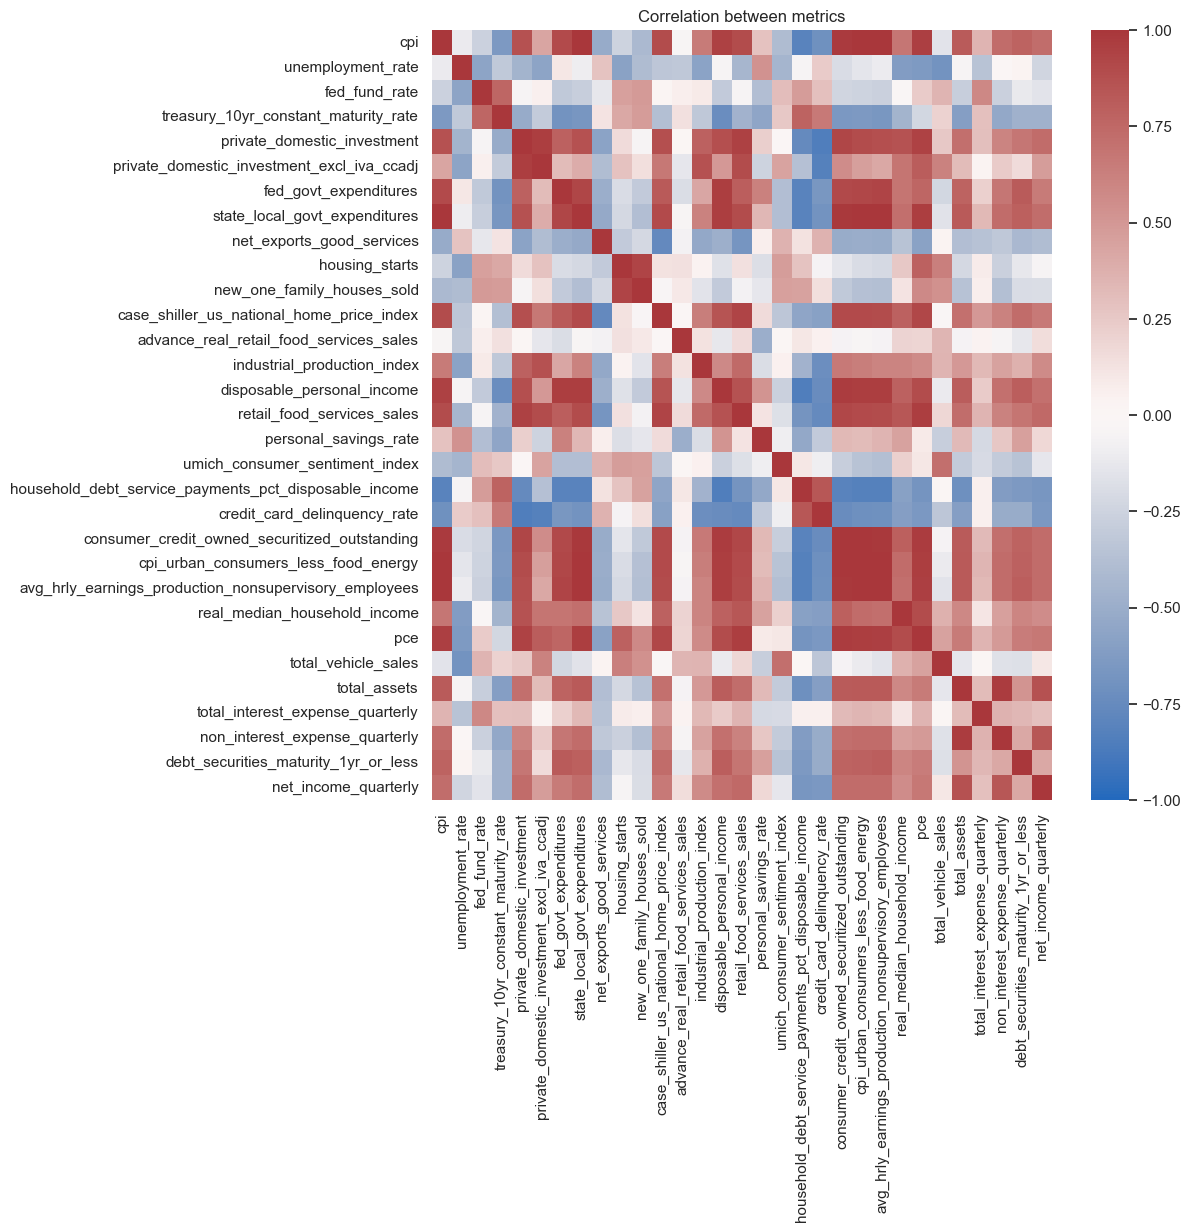

In [17]:
corr_columns = list(df.columns[6:])
sns.set(rc={"figure.figsize": (10, 10)})
sns.heatmap(df[corr_columns].corr(), vmin=-1, vmax=1, cmap="vlag").set_title(
    "Correlation between metrics"
)
plt.show()

As we can see, many metrics are highly correlated, which may create issues of collinearity. We will perform manual feature selection to accommodate for this.

<a id="supervised"></a>
# Saving data for analysis

In [18]:
df_samples["category"] = df_samples["name"].map(bank_sample_map)

In [19]:
write_feather(df, "../data_cleaned/df_train.feather")
write_feather(df_samples, "../data_cleaned/df_samples.feather")